In [1]:
import geopandas as gpd
from sqlalchemy import create_engine
import psycopg2

# import libraries
import geopandas as gpd
import pandas as pd
import numpy as np

# for interactive plots
import plotly.express as px
import seaborn
import pysal
import contextily as ctx

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from pointpats import centrography

import imageio
from IPython.display import Image

import matplotlib as mpl
# set font
mpl.rc('font',family='Hiragino Maru Gothic Pro')
# mpl.rc('font',family='YuMincho')

# library additionas for legends
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe

pd.set_option("display.max_columns", None)

import plotly.io as pio

from adjustText import adjust_text

/Users/yohkawano/opt/anaconda3/envs/geos/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/yohkawano/opt/anaconda3/envs/geos/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Import GIS layers

Make sure postgres is started via terminal:
```brew services start postgresql```

In [3]:
# Replace placeholders with your database credentials
DB_USER = ""
DB_PASSWORD = ""
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "xymax"

# Construct the connection string
connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Create the SQLAlchemy engine
con = create_engine(connection_string)

# import buildings
table_name = "SELECT * FROM h23_bv"
buildings_2011 = gpd.read_postgis(table_name, con)


In [4]:
table_names = con.table_names()
print(table_names)


['spatial_ref_sys', 'h3building', 'h8land', 'h8building', 'h23_bv', 'h3land', 'h13building']


/var/folders/09/7rqr2q_j5z180q4m1333f_qm0000gp/T/ipykernel_49702/2911410082.py:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  table_names = con.table_names()


In [5]:
# let's download reiwa 1st year data 2019
test2019 = gpd.read_file('data/kokudo/A29-19_13/01-03_GeoJSON形式/A29-19_13000.geojson')


In [13]:
# map data from plateau
p1 = gpd.read_file('data/plateau/13100_tokyo23-ku_2022_other_1_op/border.geojson')
p2 = gpd.read_file('data/plateau/13100_tokyo23-ku_2022_other_1_op/landmark.geojson')

In [18]:
gml1 = gpd.read_file('data/plateau/gml/13100_tokyo23-ku_2022_citygml_1_2_op/udx/dem/533925_dem_6697_op.gml', driver='GML')

UnsupportedGeometryTypeError: 1016

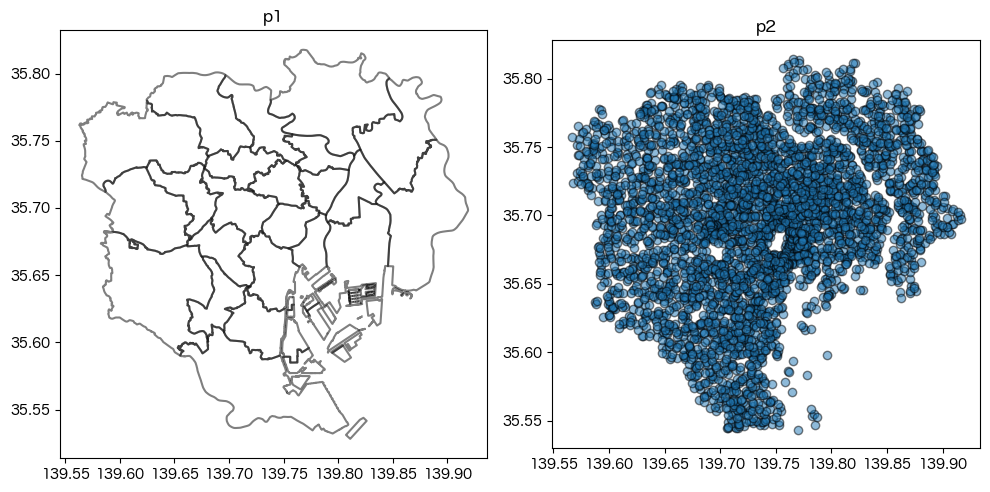

In [14]:
import matplotlib.pyplot as plt

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot p1 in the first subplot
p1.plot(ax=ax1, alpha=0.5, edgecolor='k')
ax1.set_title('p1')

# Plot p2 in the second subplot
p2.plot(ax=ax2, alpha=0.5, edgecolor='k')
ax2.set_title('p2')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


<AxesSubplot: >

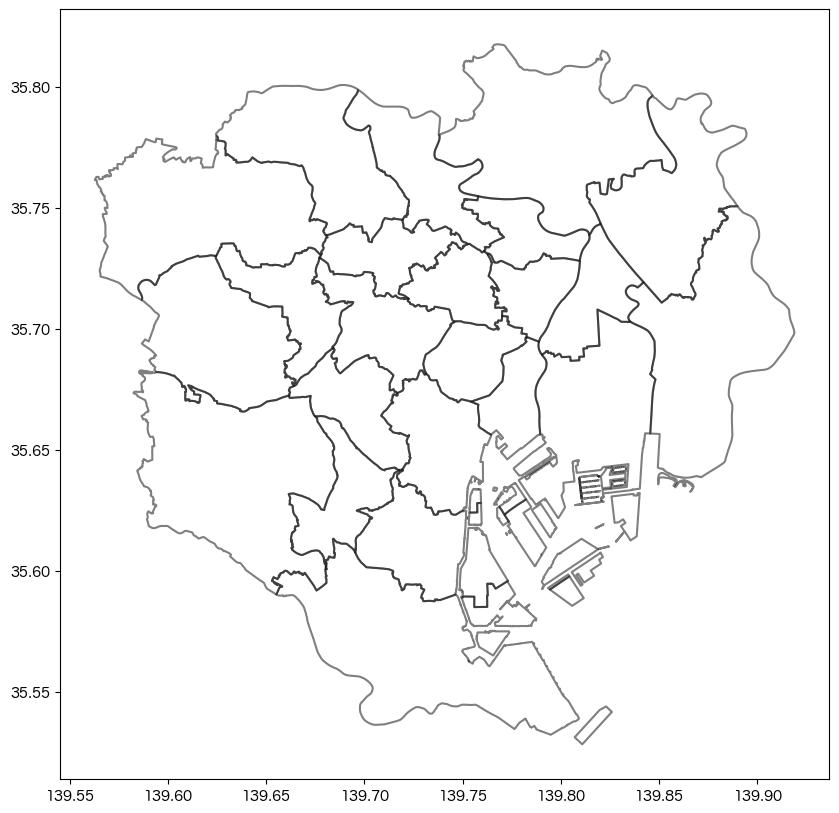

In [11]:
p1.plot(figsize=(10,10), alpha=0.5, edgecolor='k')

In [ ]:

# import tokyo cities
regions = gpd.read_file('../data/master/project_area_census_by_ku.geojson')

# import mesh
mesh = gpd.read_file('../mesh.geojson')

# project to web mercator
mesh = mesh.to_crs("EPSG:3857")
buildings_2011 = buildings_2011.to_crs("EPSG:3857")
regions = regions.to_crs("EPSG:3857")


## Building use codes

<img src="images/building table fields.jpg" width=600>

The field `bv_6` denotes the use code, based on this lookup table:

<img src="images/building use code.jpg" width=400>


Calculate building use by area. Formula is Area*BV_3.

In [ ]:
# Create a dictionary with code_id and name
lookup_data = {'code_id': [111,112,113,114,121,122,123,124,125,131,132,141,142,143,150],
               'name': ['官公庁施設','教育文化施設','厚生医療施設','供給処理施設','事務所建築物','専用商業施設','住商併用建物','宿泊・遊興施設','スポーツ・興行施設','独立住宅','集合住宅','専用工場','住居併用工場','倉庫運輸関係施設','農林漁業施設']}

# Create a DataFrame from the dictionary
building_usecodes = pd.DataFrame(lookup_data)

# Display the lookup table
print(building_usecodes)


update table with usecode name values

In [ ]:
# Create a new field 'usecode' in buildings_2011
buildings_2011['usecode'] = ''

# Iterate over each row in buildings_2011
for index, row in buildings_2011.iterrows():
    bv_6 = row['bv_6']
    
    # Find the corresponding name in building_usecodes based on bv_6
    name = building_usecodes.loc[building_usecodes['code_id'] == bv_6, 'name'].values
    
    # Update the 'usecode' field with the name
    buildings_2011.at[index, 'usecode'] = name

In [ ]:
# Remove square brackets from the usecode column
buildings_2011['usecode'] = buildings_2011['usecode'].str.join('')

In [ ]:
buildings_2011.sample(10)

Create new fields in the mesh table for 2011 usecodes

In [ ]:

# Count the occurrences of each building usecode
usecode_counts = buildings_2011['usecode'].value_counts()

# Create a bar chart of the building usecode counts
usecode_counts.plot(kind='bar')


In [ ]:
# Get the distinct usecode IDs from the building_usecodes table
distinct_names = building_usecodes['name'].unique()

# Iterate over each distinct usecode ID
for name in distinct_names:
    # Create a new column in mesh for the current usecode ID
    mesh[f'2011_{name}'] = 0


In [ ]:
# Create a copy of the buildings_2011 dataframe
buildings_2011_points = buildings_2011.copy()

# Convert the geometry column from polygons to points
buildings_2011_points['geom'] = buildings_2011_points['geom'].centroid

# Update the crs of the dataframe if needed
buildings_2011_points.crs = buildings_2011.crs



## Spatial join to add usecode counts per mesh

In [ ]:
# Create a new field 'building_count' in mesh
mesh['2011_building_count'] = 0

# Perform spatial join to count the number of buildings_2011_points that fall within each mesh
count = gpd.sjoin(buildings_2011_points, mesh).groupby('index_right').size()

# Update the '2011_building_count' field in mesh with the count
mesh['2011_building_count'] = mesh.index.map(count).fillna(0)


In [ ]:
# Iterate over each distinct usecode
for usecode in buildings_2011['usecode'].unique():
    # Perform spatial join to count the number of buildings_2011_points that fall within each mesh for the current usecode
    count = gpd.sjoin(buildings_2011_points[buildings_2011_points['usecode'] == usecode], mesh).groupby('index_right').size()
    
    # Update the corresponding column in mesh with the count for the current usecode
    mesh[f'2011_{usecode}'] = mesh.index.map(count).fillna(0)


In [ ]:
mesh.sample(10)

In [ ]:
# get rid of meshes where 2011_building_count is 0
mesh = mesh[mesh['2011_building_count'] != 0]

In [ ]:
# convert mesh to 4326
mesh = mesh.to_crs("EPSG:4326")


In [ ]:
# Calculate the center latitude and longitude of the mesh bounding box
min_x, min_y, max_x, max_y = mesh.total_bounds
center_lat = (min_y + max_y) / 2
center_lon = (min_x + max_x) / 2

# Print the center latitude and longitude
print("Center Latitude:", center_lat)
print("Center Longitude:", center_lon)



In [ ]:
import leafmap.kepler as leafmap
m = leafmap.Map(center=[center_lat,center_lon], zoom=12)
m.add_gdf(mesh, "Tokyo cities", config='kepler_tokyo_config.json')
m

In [ ]:
m.save_config("kepler_tokyo_config.json")

In [ ]:
# save mesh as geojson
mesh.to_file("data/mesh2011.geojson", driver='GeoJSON')


## Old stuff

In [ ]:
# import buildings
table_name = "SELECT * FROM H3building"
h3 = gpd.read_postgis(table_name, con)

In [ ]:
distinct_counts = h3['主用途cd'].value_counts()
print(distinct_counts)


In [ ]:
# import tokyo cities
regions = gpd.read_file('../data/master/project_area_census_by_ku.geojson')

In [ ]:
# put the ku's in a list
kus = regions['SIKUCHOSON'].unique().tolist()

In [ ]:
# Perform spatial join to assign city to buildings
result = gpd.sjoin(h3, regions, how='left', op='intersects')

# Create a new "city" column in the result GeoDataFrame
result['city'] = result['SIKUCHOSON']

In [ ]:
# result.to_file('h3.geojson', driver='GeoJSON')


In [ ]:
result['centroid'] = result['geom'].centroid
result_points = result.copy()
result_points['geometry'] = result_points['centroid']
result_points = result_points.set_geometry('geometry')


In [ ]:
# import mesh
mesh = gpd.read_file('../mesh.geojson')


In [ ]:
# Project mesh to EPSG 4326
mesh = mesh.to_crs("EPSG:4326")

# Project result_points to EPSG 4326
result_points = result_points.to_crs("EPSG:4326")


In [ ]:
# Get the distinct values of 主用途cd from result_points
distinct_cd_values = result_points['主用途cd'].unique()
distinct_cd_values

In [ ]:

# Iterate over each distinct 主用途cd
for cd in distinct_cd_values:
    # Create a new column in mesh for the current 主用途cd
    mesh[f'count_{cd}'] = 0
    


In [ ]:
mesh

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot mesh
mesh.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot result_points
result_points.plot(ax=ax, color='red', markersize=1)

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Result Points on Mesh')

# Show the plot
plt.show()


In [ ]:
# project mesh and result_points to web mercator
mesh = mesh.to_crs("EPSG:3857")
result_points = result_points.to_crs("EPSG:3857")


In [ ]:
# delete index_right from result_points
result_points = result_points.drop('index_right', axis=1)

In [ ]:
# Perform spatial join to count the number of result_points that fall within each mesh
count = gpd.sjoin(result_points, mesh, how='left', op='intersects').groupby('index_right').size()

# Update the corresponding column in mesh with the count
mesh['count_result_points'] = mesh.index.map(count).fillna(0)


In [ ]:
# Iterate over each distinct 主用途cd
for cd in distinct_cd_values:
    # Perform spatial join to count the number of buildings for each 主用途cd
    count = gpd.sjoin(result_points[result_points['主用途cd'] == cd], mesh, how='left', op='intersects').groupby('index_right').size()
    
    # Update the corresponding column in mesh with the count
    mesh[f'count_{cd}'] = mesh.index.map(count).fillna(0)


In [ ]:
# delete mesh rows where count_result_points is 0
mesh = mesh[mesh['count_result_points'] != 0]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the choropleth map
mesh.plot(column='count_131', 
          cmap='YlOrRd', 
          linewidth=0.8, 
          ax=ax, 
          edgecolor='none', 
          legend=True, 
          alpha=0.7, 
          legend_kwds={'label': "Count 131", 'orientation': "horizontal", 'shrink': 0.5, 'pad': 0.01})

# add ku borders
ku.boundary.plot(ax=ax, color='black', linewidth=0.8, alpha=0.2)

# label ku's
texts = []
for x, y, label in zip(ku.geometry.centroid.x, ku.geometry.centroid.y, ku['SIKUCHOSON']):
    if mesh.total_bounds[0] <= x <= mesh.total_bounds[2] and mesh.total_bounds[1] <= y <= mesh.total_bounds[3]:
        texts.append(plt.text(x, y, label, fontsize=8, fontweight='bold', ha='center', va='center', color='black'))

# zoom to extent of mesh bounds with a 5km buffer
ax.set_xlim([mesh.total_bounds[0] - 5000, mesh.total_bounds[2] + 5000])
ax.set_ylim([mesh.total_bounds[1] - 5000, mesh.total_bounds[3] + 5000])

# hide axes
ax.axis('off')

# Set axis labels and title
ax.set_title('主用途 131')

# ctx.add_basemap(ax, source='https://cyberjapandata.gsi.go.jp/xyz/pale/{z}/{x}/{y}.png')
# ctx.add_basemap(ax, source='https://cyberjapandata.gsi.go.jp/xyz/blank/{z}/{x}/{y}.png')
ctx.add_basemap(ax, source='https://cyberjapandata.gsi.go.jp/xyz/seamlessphoto/{z}/{x}/{y}.jpg')

plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# sort mesh by count_result_points
mesh = mesh.sort_values('count_result_points', ascending=False)
mesh

In [ ]:
def building_by_ku_and_cd(ku='千代田区', 主用途cd=131):
    
    # number_of_buildings = len(result[(result['SIKUCHOSON']==ku) & (result['主用途cd']==主用途cd)])
    number_of_buildings = len(result[(result['SIKUCHOSON']==ku)])
    # print(number_of_buildings)
    if number_of_buildings > 0:
        fig, ax = plt.subplots(figsize=(8,8))
        
        subtitle_text = str(number_of_buildings)+' buildings'

        # Title text and font sizes
        line1_text = ku
        line2_text = str(len(result[(result['SIKUCHOSON']==ku) & (result['主用途cd']==主用途cd)]))+' buildings'
        line1_fontsize = 50
        line2_fontsize = 12

        # Define outline color and width
        outline_color = 'white'
        outline_width = 2

        # Add title lines with outline color within the chart area
        title1 = ax.text(0.5, 0.7, line1_text, fontsize=line1_fontsize, ha='center', va='center', transform=ax.transAxes)
        title2 = ax.text(0.5, 0.61, line2_text, fontsize=line2_fontsize, ha='center', va='center', transform=ax.transAxes)

        # Create an outline effect for the title text
        title1.set_path_effects([plt.matplotlib.patheffects.withStroke(linewidth=outline_width, foreground=outline_color)])
        title2.set_path_effects([plt.matplotlib.patheffects.withStroke(linewidth=outline_width, foreground=outline_color)])

        result[(result['SIKUCHOSON']==ku) & (result['主用途cd']==主用途cd)].plot(ax=ax, column='主用途cd', linewidth=0.1, edgecolor='red', alpha=1,facecolor='red')
        result[(result['SIKUCHOSON']==ku)].plot(ax=ax, linewidth=0.1, edgecolor='black', alpha=0.1)
        # result[(result['SIKUCHOSON']==ku) & (result['主用途cd']==主用途cd)].plot(ax=ax, column='主用途cd', cmap='viridis', linewidth=0.1, edgecolor='black', alpha=0.8)
        ax.axis('off')
       
        # Save the plot as an image file (e.g., PNG, JPEG, PDF, SVG)
        # output_file = ku + '_' + 主用途cd + '.png'  
        # plt.savefig(output_file, dpi=300, bbox_inches='tight')  # You can adjust the DPI and other settings

ku = '千代田区'
distinct_cd_values = result[result['SIKUCHOSON']==ku]['主用途cd'].unique()
for cd in distinct_cd_values:
    building_by_ku_and_cd(ku, cd)

# for ku in kus:
#     distinct_cd_values = result[result['SIKUCHOSON']==ku]['主用途cd'].unique()
#     for cd in distinct_cd_values:
#         building_by_ku_and_cd(ku, cd)


In [ ]:
building_by_ku_and_cd()

In [ ]:
for ku in kus:
    building_by_ku(ku)